#### Example: Methane in a 2033 $\text{m}^3$ tank for the new modelation of k_V, a more realistic method 

This application corresponds to liquid hydrogen storage in the NASA's Space Launch System. It consists of a 2033 $m^3$ storage tank [NASA](https://www.energy.gov/sites/default/files/2021-10/new-lh2-sphere.pdf) in a tank with 8.4 m diameter and 40 m height. It will be assumed the following operation scenarios:

* Daily boil-off rate of 0.1%  
* Storage at atmospheric pressure with continuous removal of boil-off gas

For purposes of the example, it is assumed that the storage tank is passively insulated with perlite. And consider a high vapour overall heat transfer coefficient W/m^2/K to observe the impact of using an average k_V versus a variable k_V

In [1]:
# Ensure that python finds the submodules
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

#### Setup tank and cryogen properties


In [21]:
# Step 2: Initialise tank object
Q_roof = 0   		# Roof heat ingress / W
d_i = 8 	    	# Internal diameter / m
d_o = 8.4   		# External diameter / m
T_air = 293.15 		# Temperature of the environment K
U_L = 3.73e-3 		# Liquid overall heat transfer coefficient W/m^2/K
U_V = 1		# Vapour overall heat transfer coefficient W/m^2/K
Q_b = 100 		    # Heat transfer rate at the bottom / W
V_tank = 2033   	# Tank volume / m^3
LF = 0.50     		# Initial liquid filling / -
P = 101325  		# Tank operating pressure / Pa

mid_tank = Tank(d_i, d_o, V_tank, LF) # Initialize mid-scale tank
mid_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b, Q_roof, eta_w= 0.8,k_V_avg = False)

# Step 3: Initialise cryogen
methane = Cryogen(name = "methane")
methane.set_coolprops(P)
mid_tank.cryogen = methane

# Step 4: Simulation setup

# Calculate initial evaporation rate
print("The initial evaporation rate of " + methane.name + " is %.1f kg/h" % (mid_tank.b_l_dot * 3600)) 
# Estimate transient period duration
print("Transient period = %.3f s " % mid_tank.tau)
# Minimum number of hours to achieve steady state 
tau_h = (np.floor(mid_tank.tau / 3600) + 1)

# Print simulation time of the transient period for short-term storage
print("Simulation time: %.0i h" % tau_h )

# Calculate boil-off rate
BOR = (mid_tank.b_l_dot * 24 * 3600) / (mid_tank.V * mid_tank.LF * mid_tank.cryogen.rho_L)
print("BOR = %.3f %%" % (BOR * 100))

dz = 0.1 # grid spacing / m
n_z = 1 + int(np.round(mid_tank.l_V/dz, 0)) # Number of nodes
mid_tank.z_grid = np.linspace(0, 1, n_z) # Set dimensionless grid
mid_tank.U_roof = 0 # Roof overall heat transfer coefficient W/m^2/K
evap_time = 3600 * tau_h # Define evaporation time / s
mid_tank.time_interval = 60 # Time-step to record data
mid_tank.plot_interval = evap_time/6 # Interval to plot vapour temperature profiles
mid_tank.evaporate(evap_time) # Simulate the evaporation


The initial evaporation rate of methane is 549.3 kg/h
Transient period = 24202.344 s 
Simulation time: 7 h
BOR = 3.071 %


### Visualisation of results

#### Vapour temperature

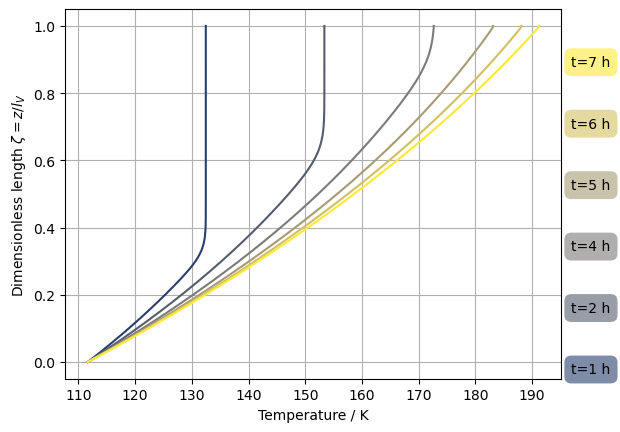

In [6]:
mid_tank.plot_tv(t_unit='h')

Visualise liquid and vapour heat ingresses, $\dot{Q}_{\text{L}}$ and  $\dot{Q}_{\text{V}}$.

The plot also shows the vapour to liquid heat ingress, $\dot{Q}_{VL}$, and  the partition of the vapour heat ingress that is transferred to the interface by the wall directly, $\dot{Q}_{\text{V,w}}$

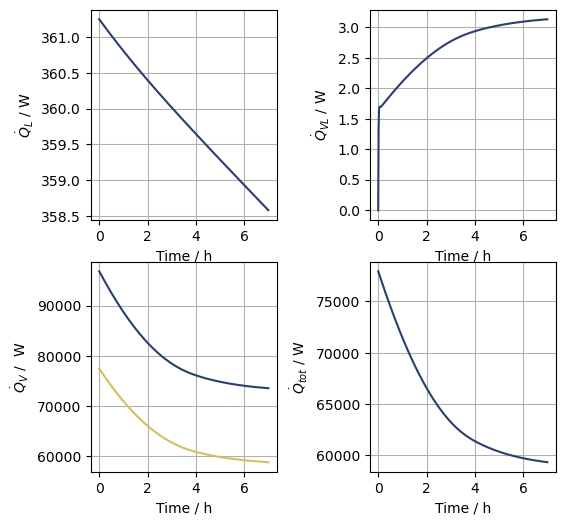

In [7]:
# Specify y-axis units as W, and time units to hours
mid_tank.plot_Q(unit = 'W', t_unit = 'h')

#### Plot liquid volume

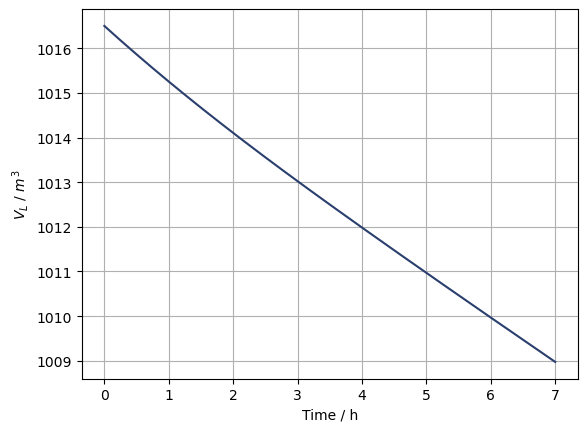

In [8]:
mid_tank.plot_V_L(t_unit='h')

#### Plot evaporation rate, $\dot{B}_{\text{L}}$, and boil-off gas rate, $\dot{B}_{}$ and Tv BOG

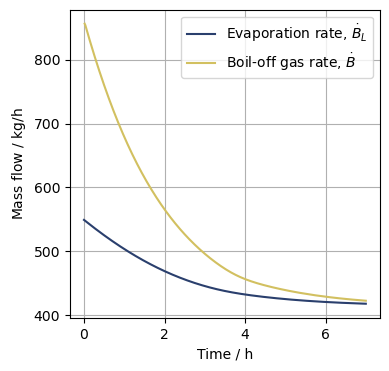

In [9]:
mid_tank.plot_BOG(unit='kg/h', t_unit='h')

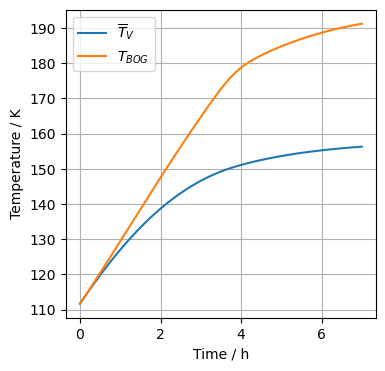

In [10]:
mid_tank.plot_tv_BOG(t_unit= "h")

In [11]:
alpha_V = (mid_tank.cryogen.k_V /
           (mid_tank.cryogen.rho_V_avg * mid_tank.cryogen.cp_V_avg))

Pe = mid_tank.v_z * mid_tank.l_V/alpha_V
print("Pe = %.3f" % Pe)

Pe = 6235.546


We also calculate the relative dominance of the wall heating source terms through the dimensionless parameters

$$\Pi_1 = \frac{S l^2}{\alpha}; \Pi_2 = \frac{Sl}{\bar{v}_z} $$

Where 
$$ S = \frac{4U_V d_o}{\rho_V \hat{c}_p d_i^2} \times \frac{l_0^2}{\alpha} $$

In [12]:
Pi_1 = 4 * mid_tank.U_V * mid_tank.d_o / (mid_tank.d_i**2 *
                                      mid_tank.cryogen.rho_V_avg * 
                                      mid_tank.cryogen.cp_V_avg *
                                      alpha_V) * mid_tank.l_V**2
Pi_2 = Pi_1/Pe
print("Pi_1 = %.3f" % Pi_1)
print("Pi_2 = %.3f" % Pi_2)

Pi_1 = 18961.243
Pi_2 = 3.041


Plot average vapour and boil-off gas temperature

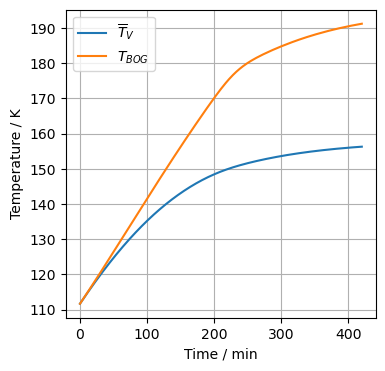

In [13]:
mid_tank.plot_tv_BOG(t_unit='min')

Save data with k_V_avg = 'True'

In [20]:
BOG_avg = np.copy(mid_tank.data['BOG'])
T_v_avg = np.copy(mid_tank.data['Tv_avg'])
T_BOG_avg = np.copy(mid_tank.data['T_BOG'])

Rerun code with k_V_avg = 'False'

In [22]:
BOG_var = np.copy(mid_tank.data['BOG'])
T_v_var = np.copy(mid_tank.data['Tv_avg'])
T_BOG_var = np.copy(mid_tank.data['T_BOG'])

Quadratic Error 

In [23]:
Erqm_BOG = np.sqrt(np.mean((BOG_var - BOG_avg)**2))
Mae_BOG = np.mean(np.abs(BOG_var - BOG_avg))

Erqm_T_v = np.sqrt(np.mean((T_v_var - T_v_avg)**2))
Mae_T_v = np.mean(np.abs(T_v_var - T_v_avg))

Erqm_T_BOG = np.sqrt(np.mean((T_BOG_var - T_BOG_avg)**2))
Mae_T_BOG = np.mean(np.abs(T_BOG_var - T_BOG_avg))


In [24]:

print(f"Error BOG")
print(f"Root Mean Square Error: {Erqm_BOG:.2e}")
print(f"Mean Absolute Error: {Mae_BOG:.2e}")
print(f"Error Tv")
print(f"Root Mean Square Error: {Erqm_T_v:.2e}")
print(f"Mean Absolute Error: {Mae_T_v:.2e}")
print(f"Error T_BOG")
print(f"Root Mean Square Error: {Erqm_T_BOG:.2e}")
print(f"Mean Absolute Error: {Mae_T_BOG:.2e}")

Error BOG
Root Mean Square Error: 3.22e-06
Mean Absolute Error: 2.21e-06
Error Tv
Root Mean Square Error: 4.34e-03
Mean Absolute Error: 3.29e-03
Error T_BOG
Root Mean Square Error: 2.75e-03
Mean Absolute Error: 1.75e-03


#### References

U.S. Department of Energy. (2021, October). DOE/NASA Advances in Liquid Hydrogen Storage Workshop. Retrieved from [https://www.energy.gov/sites/default/files/2021-10/new-lh2-sphere.pdf]